Make a matrix n x n with change in synaptic strength(w_final - w_initial) being color coded. 

Consider making the delta w (change in connection strength) not so small for each spike so I dont have to run it forever before seeing changes. 

when adding in the only-potentiating portion for hgiher frequency spiking, just flip the negative w portion so that it is positive, making an increase in delta w until delta t = 0, then back down to 0 at about delta t = +30 ms. 

### Questions

 - if the NMDA receptors for plasticity only work when both the pre and post are both depolarized, then why don't I just use that as my condition for plasticity instead of the time interval between spikes? Wouldn't it be more accurate? - Yes but then I would have to track the voltage continuously, bad for program efficiency. 

 
 
 - How should I determine the spiking frequency between pairs of neurons? What if one is spiking fast and the other slow? - I am going to measure the time between pairs of spikes. If a given pair of neurons spike within 200 ms of their last spike together, then I will apply the potentiation-only rule. If the period between these pairs is longer, then I apply the bidirectional rule. 
    
    


Clearing up, should confirm with Michal: *

Neurons have high concentrations of K+ ions inside them. When there is no ACh, these K+ ions can flow outside the cell in order to repolarize it(making the neuron more negative)(open channel -> high gks). In the presence of ACh, G proteins close these ion channels (low gks) and prevent the outflow of K+ ions, thus making repolarization more difficult. Is this correct? If so, why should this stop neurons from firing? Shouldn't this allow the neurons to fire and then just remain at higher voltages? - Thesse K+ channels hyperpolarize the cell, making it fire less. This has nothing to do with spiking of neuron. When ACh is low, this channel is open all the time, constantly depolarizing the cell and making it more difficult to spike.

### Changes
Code taken from "SST Varying conn and gks".ipynb


- Started using self.connectionWeights to record synaptic plasticity changes. Initialized as a list of 1s, then to be changed according to plasticity rules for every spike. 


 - Changed updateSpikeTime() to include plasticity changes.
 
 
 - Added several new functions - plot_voltage(), plot_weight(), reorder_matrix_plot(), and changed plot_sorted() so that it returns the sorted list of neurons used in the raster plot. This is then used to sort the connection and weight matrices. EDIT: Combined reorder_matrix_plot() and plot_sorted(), now plot_sorted does not return a value.

In [2]:
import numpy as np
import scipy as scipy
import matplotlib.pyplot as plt
import random as RD
from matplotlib import colors
import winsound

In [10]:
#It is important to leave numEquations and stepSize here, as they affect the integration.
numEquations = 4
stepSize = 0.1
simLength = 1500
tarray = np.arange(0,simLength,stepSize)
Ntimes = len(tarray)

spikeThreshold = 5 #Sets the voltage at which a spike is recorded. 

numnrn = 100 #Number of neurons in the model.

numSST = 20 #Number of SST neurons to be forced into the model.
percent_SST = 0 #Percent of neurons to be randomly assigned as SST interneurons.

c_e, c_i = 0.1, 0.5#Percent connectivity. Excitory, Inhibitory.  
p_e, p_i = 0.8, 0 #Probabilty of an existing connection breaking and forming a new connection. Excitory, Inhibitory. 
local_conn = True #When true, new connections can be formed with local connections. When false, only non-local new
# connections are formed.

gks_E = 1 #ACh level of excitatory neurons. Type I is gks=0, Type II gks=1.5.
gks_SST = 1 # ACh level for SST neurons

Idrive_min, Idrive_max = 0.5,0.5 # Range for possible random Idrives. For excitory neurons.
Idrive_SST = -0.1 #The Idrive for SST neurons. Should be low enough so that they do not fire without synaptic input. 

makeSound = True


class neuron:
        
    def __init__(self):
        self.ID = 0
        self.position = []
        self.connections = [] #List of connection strengths to other neurons. Is tuple like [[postsyn,conn],[postsyn,conn]...]
        self.connectionWeights = [] #Holds changes made from plasticity. For self as presynaptic nrn. 
        self.Input_syn = 0
        self.Input_noise = 0
        self.Input_external = 0
        self.spikeTimes = [] # Set to record a spike when membrane voltage breaches variable spikeThreshold.
        self.prevActivity = 0
        self.neuronsInRange = [] #Tracks the # of neurons in range so as to minimize looping time during connection growth function
        self.solutions = np.zeros(numEquations) #Why is this a comment? And why then does nrn.solutions still function?
        
        #Things I have added in myself:
        self.spike = False #Determines whether the neuron has already spiked or not. 
        self.Idrive = 0
        self.color = '' #Color of neuron for graphing.
        self.conn_in = [] #Connections coming in from other neurons. Sum is the in-degree of the neuron. Note, not tuple like self.connections.
        # Format is 1D list of connection strengths, where list index is presynaptic neuron. 
        self.category = 'Excitatory' #Labels the neuron type. Default is excitatory, can be chanegd to inhibitory. 
        self.gsyn = 1 # Connection strength multiplier.
        
        
        
def equations(solns_, eqn, Isyn, Idrive,nrn):
    # These equations are parameters are adjusted to fit fast-spiking interneurons.
    
    tempVal = 0
    
    category = nrn.category
    
    if category == 'Excitatory':
        gks = gks_E
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn )/C
            
    elif category == 'SST':
        gks = gks_SST
        C = 1 
        gna = 24
        gkdr = 3
        gl = 0.02
        Vna = 55
        Vk = -90
        Vl = -60
        if(eqn == 0):
            hinf = 1/(1+np.exp((solns_[3]+53)/7))
            tauh = .37 + 2.78/(1+np.exp((solns_[3]+40.5)/6))
            tempVal = (hinf - solns_[0])/tauh 
        elif(eqn == 1):
            ninf = 1/(1+np.exp((-solns_[3]-30)/10))
            taun = .37 + 1.85/(1+np.exp((solns_[3]+27)/15))
            tempVal = (ninf - solns_[1])/taun
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            m = 1/(1+np.exp((-solns_[3]-30)/9.5))
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn )/C
            
    elif category == 'PV+':
        C = 1 
        gna = 35
        gkdr = 9
        gl = 0.1
        Vna = 55
        Vk = -90
        Vl = -65    
        if(eqn == 0):
            a_h = 0.07*np.exp(-(solns_[3]+58)/20)
            b_h = 1/(np.exp(-0.1*(solns_[3]+28))+1)
            phi = 5
            tempVal = phi*(a_h*(1-solns_[0]) - b_h*solns_[0])
        elif(eqn == 1):
            a_n = -0.01*(solns_[3]+34)/(np.exp(-0.1*(solns_[3]+34))-1)
            b_n = 0.125*np.exp(-(solns_[3]+44)/80)
            phi = 5
            tempVal = phi*(a_n*(1-solns_[1])-b_n*solns_[1])
        elif(eqn == 2):
            zinf = 1/(1+np.exp((-solns_[3]-39)/5))
            tempVal = (zinf - solns_[2])/75
        elif(eqn == 3):
            a_m = -0.1*(solns_[3]+35)/(np.exp(-0.1*(solns_[3]+35))-1)
            b_m = 4*np.exp(-(solns_[3]+60)/18)
            m = a_m/(a_m+b_m)
            tempVal = (-gna*(m**3)*solns_[0]*(solns_[3]-Vna) - gkdr*(solns_[1]**4)*(solns_[3]-Vk) 
                       - gks*solns_[2]*(solns_[3]-Vk) - gl*(solns_[3]-Vl) + Idrive - Isyn )/C
        
    return tempVal


def RK4(t_ind):
    
    global neuron
    
    for nrn in neurons:
        
        solns = nrn.solutions
        Isyn = nrn.Input_syn
        Idrive = nrn.Idrive
        k1 = np.zeros(numEquations)
        k2 = np.zeros(numEquations)
        k3 = np.zeros(numEquations)
        k4 = np.zeros(numEquations)
        
        init_solns = solns
        
        #Calculates the k1 variables
        for ii in range(len(solns)):
            k1[ii] = stepSize*equations(solns, ii,Isyn,Idrive,nrn)

        #Calculates the k2 variables
        for ii in range(len(solns)):
            k2[ii] = stepSize*equations(solns+k1/2, ii,Isyn,Idrive,nrn) #important fix done here. solns must be advanced by k
                                                                    #for calculation of the next k variable.
        #Calculates the k3 variables
        for ii in range(len(solns)):
            k3[ii] = stepSize*equations(solns+k2/2, ii,Isyn,Idrive,nrn) 

        #Calculates the k4 variables
        for ii in range(len(solns)):
            k4[ii] = stepSize*equations(solns+k3, ii,Isyn,Idrive,nrn)
        
        #Updates the general solution
        for ii in range(len(solns)):
            solns[ii] = init_solns[ii] + (k1[ii] + 2*k2[ii] + 2*k3[ii] + k4[ii])/6 
            nrn.solutions[ii] = solns[ii]
            
            
            
def init_nrn(numnrn): #initializes neurons and assigns ID, connections, weights, etc. 
    global neuron
    neurons = [] #List containing neuron objects
    nconn_Mat = [np.empty(3)] # 2D matrix for storing new connections.
    
    
    def count_SST(neurons): # A function for counting the number of SST neurons.
        count = 0
        for nrn in neurons:
            if nrn.category == 'SST':
                count += 1
        return count

    
    for i in range(numnrn):  
        neurons = np.append(neurons,neuron()) #Intiallizes numnrn number of neurons

    ID = 0
    count_excitatory = 0
    for nrn in neurons: #assigns neurons in list their IDs, init voltage, Idrive, etc.
        nrn.ID = ID
        ID += 1 
        #if RD.random() <= percent_SST:
            #nrn.category = 'SST' #Assigns 'percent_SST' portion of neurons.
        
        # In order to fix the number of SST neurons while still distributing them throughout to network:
        num_SST = count_SST(neurons) #Counts the current number of SST neurons.
        if RD.random() < 0.27 and num_SST < numSST: #limits the number of SST neurons to (second number). letting RD.random < (first number) ensures there will be 1# neurons somewhat spread out.
            nrn.category = 'SST' #Assigns neuron as a SST neuron. Usually, percent_(*neuron type*) equals zero.
        # IMPORTANT: This will always assign 20 SST neurons to the network, so make sure to adjust when changing network size.
            
        nrn.spikeTimes = []
        nrn.solutions = [RD.random(),RD.random(),RD.random(),RD.uniform(-55,-20)] #Initial conditions of each neuron. Initial voltage randomly assigned between -55 and -20 mV.
        #nrn.gsyn = round(RD.uniform(0,3),4) #Chooses a connection multiplier between 0 and x.
        nrn.connectionWeights = [1]*numnrn #Creates a list of all connection weights to other neurons at value 1. 

        if nrn.category == 'Excitatory':
            nrn.color = 'Blue' #Excitory neurons given blue color for Raster plot.
            nrn.Idrive = round(RD.uniform(Idrive_min, Idrive_max),3) #Random value between min and max rounded to 1 decimal places
            
            count_excitatory += 1 #Counts number of excitatory neurons.
            if count_excitatory < 40: # Sets a fixed number of neurons to specific gsyn values. 
                nrn.gsyn = 0.5
            else:
                nrn.gsyn = 2.5
                
        if nrn.category == 'SST':
            nrn.color = 'Red' #Inhibitory given red.
            nrn.Idrive = Idrive_SST #Idrive for inhibitory neurons. 
        if nrn.category == 'PV+':
            nrn.color = 'darkorange'
            nrn.Idrive = round(RD.uniform(Idrive_PVplus_min,Idrive_PVplus_max),3)
    print('Number SST ',num_SST)
    
    conn_Matrix = np.zeros((numnrn,numnrn)) #initializes matrix of zeros with numnrn x numnrn size. Row = nrn #, Column = connected nrn #
    # Fills matrix with connectivity based on proximity. conn_span # of neurons to right and left are given full connection. 
    for row_index, row in enumerate(conn_Matrix):
        for column_index, conn in enumerate(row):
            
            if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
                conn_span = int(c_e*numnrn/2) #number of neurons to be connected on either side of a neuron.

                #sets neurons at +- conn_span from diagonal to full connectivity.
                if column_index >= row_index-conn_span and column_index <= row_index+conn_span:
                    conn = 1 
                #Full connectivity at edge case of first neurons connected to last neurons in ring.
                elif row_index-conn_span < 0 and column_index >= numnrn+row_index-conn_span:
                    conn = 1
                #Full connectivity at edge case of last neurons connected to first neurons in ring.
                elif row_index+conn_span > (numnrn-1) and column_index <= row_index-numnrn+conn_span:
                    conn = 1 
                #All other neurons have zero connectivity.
                else:
                    conn = 0
                # Sets diagonal entries to zero.
                if column_index == row_index:
                    conn = 0
                    
            elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+': # If the presynaptic neuron is inhibitory.
                if RD.random() <= c_i and column_index != row_index: # if a random between 0 and 1 is less than the connectivity percent. 
                    conn = 1
                else:
                    conn = 0
                    
            row[column_index] = conn  #Assigns the local connections.
        conn_Matrix[row_index] = row

    # Changes connections based on proability p. 
    for row_index, row in enumerate(conn_Matrix): 
        row_temp = row.copy() #used to store changes while deleting connections from new_conn_list. VERY IMPORTANT TO USE .copy()
         # otherwise row will change when row_temp is changed. This is how assignment works. 
        if neurons[row_index].category == 'Excitatory': #Determines which connectivity percent to use based on neuron category.
            conn_span = int(c_e*numnrn/2) #number of neurons to be connected on either side of a neuron.
            p = p_e
        elif neurons[row_index].category == 'SST' or neurons[row_index].category == 'PV+':
            conn_span = int(c_i*numnrn/2)
            p = p_i 

        for column_index, conn in enumerate(row):
            
            if conn != 0: #only for existing connections.
                if RD.random() <= p: # RD.random() selects random float between 0 and 1.

                    if local_conn == True: # Allows new local connections.
                        new_conn_list = np.append(np.arange(0,row_index,1),np.arange(row_index+1,numnrn,1)) #Creates list of
                        #all nrn IDs besides self.
                    if local_conn == False: #No new local connections.
                        #List of all nrns except local and self. Very gross and uses heaviside functions. May be simplifiable. 
                        new_conn_list = np.append(np.arange(numnrn - numnrn*np.heaviside(row_index-conn_span-1, 1)
                                    +(row_index+conn_span-numnrn+1)*np.heaviside(row_index+conn_span-numnrn,1),row_index-conn_span,1),
                                    np.arange(row_index+conn_span+1,(numnrn+row_index-conn_span)-
                                    (row_index-conn_span)*np.heaviside(row_index-conn_span, 1),1))
                     
                    for index, val in enumerate(row_temp):#Deletes established conns from new_conn_list, preventing double connections.

                        if val != 0: #Sorts out only established conns.
                            delindex = np.where(new_conn_list == index) #Finds where est. conn lies in new_conn_list.
                            if len(delindex[0]) > 0: #Stops error from having nothing to delete when local_conn = False. 
                                delindex = delindex[0][0] #grabs useful integer.
                                new_conn_list = np.delete(new_conn_list, delindex) #deletes from possible conns. 
    
                    nconn = RD.choice(new_conn_list) #Randomly selects one neuron to connect to. 
                    nconn_info = [[row_index, column_index, nconn]] # [neuron #, old connection, new connection]. Must be 2D.
                    nconn_Mat = np.concatenate((nconn_Mat,nconn_info)) #Adds this info to a matrix for later use.
                    
                    #Updates values of the array used in determining new connections. 
                    row_temp[int(column_index)] = 0 
                    row_temp[int(nconn)] = 1


    nconn_Mat = np.delete(nconn_Mat,0,0) #Removes np.empty dummy row from matrix.
    
    #Apply new connection changes.
    for info in nconn_Mat:
        conn_Matrix[int(info[0]),int(info[1])] = 0 #Sets old connection to zero.
        conn_Matrix[int(info[0]),int(info[2])] += 1 #Establishes connection or adds another connection.

    nc_Matrix = np.empty((numnrn,numnrn,2)) #Empty matrix to hold final values. nc means neuron # and connection strength. 
    count = 0
    # Creates 3D array, nc_matrix, storing (nrn #, conn strength to nrn receiving Isyn)
    for row in conn_Matrix:
        conn_tuple = list(enumerate(row)) #list of tuples with info (postsyn nrn #, recieving nrn conn strength)
        nc_Matrix[count] = conn_tuple 
        count += 1

    
#Assigns neuron objects the list of tuple connections. 
    for nrn in neurons:
        nrn.connections = nc_Matrix[nrn.ID] #Outgoing connections for nrn.
        nrn.conn_in = nc_Matrix[:,nrn.ID][:,1]# Incoming connections for nrn. [0,0,1,1] would mean this neuron recieves no
        # signal from neurons 0 and 1, and full signal from neurons 2 and 3. 
    
    #Prints standard dev of Idrives
    sum_Idrive = 0
    for nrn in neurons:
        sum_Idrive += nrn.Idrive
    avg_Idrive = sum_Idrive/numnrn
    temp=0
    for nrn in neurons:
        temp += (nrn.Idrive - avg_Idrive)**2
    std = np.sqrt(temp/numnrn)
    print('Standard Deviation of Idrives: ',round(std,3))
        
    return neurons,nc_Matrix
            
            
def updateSyn(t_ind): #Gives synaptic input to all neurons on connection list
    #Ignores changes in synaptic strengths. t_start is the time at which the presynaptic neuron's voltage breaches -20 mV.
    # Has been changed to normalize strength of inputs to a neuron by number of inputs. I.e sum of all inputs comes to w_max. 
    t_temp = 0 
    global neuron

    # AMPA connections
    w_EE = 0.15
    w_EI = 0.08
    # GABA A connections
    w_II = 0.15
    w_IE = 0
    # GABA B connections
    w_II_B = 0
    w_IE_B = 0.038
    
    tau = 0.5 #Time constant for fast-acting receptors.
    tau_B = 50 # Time constant for GABA B receptors, slow-acting.
    
    for nrn in neurons:          
        if len(nrn.spikeTimes) > 0: # To prevent errors of calling [-1] from an array without any entries. Can change to be l > 2, 3 ...
            t_temp = nrn.spikeTimes[-1] #grabs time this neuron spikes at.

            for conn in nrn.connections: #Gives all connected neurons Isyn corrspondping to their voltage.
                V = neurons[int(conn[0])].solutions[3] #Voltage of postsynaptic neuron. Note conn[1] is the connection strength and conn[0] is the ID.
                Isyn = 0 
                
                if nrn.category == 'SST' or nrn.category == 'PV+': # Handles GABA A and B receptors in postsyn  neurons.
                    E_syn = -75 #Chloride reversal potential. 
                    if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For I-I connections.
                        for w,t in (w_II,tau),(w_II_B,tau_B): #Sends two signals, one with w_II/tau and one with w_II_B/tau_B. 
                            Isyn += conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t is tau here. 
                    if neurons[int(conn[0])].category == 'Excitatory': # For I->E connections.
                        gsyn = neurons[int(conn[0])].gsyn #Connection strength multiplier of postsynaptic neuron.
                        for w,t in (w_IE,tau),(w_IE_B,tau_B):
                            Isyn += gsyn*conn[1]*(w)*np.exp(-stepSize*(t_ind-t_temp)/t)*(V - E_syn) # t = tau again. 
                            
                if nrn.category == 'Excitatory':
                    E_syn = 0 # Sodium reversal potential. E_syn = 0 for excitory synapse and E_syn = -75 mV for inhibitory synapse
                    if neurons[int(conn[0])].category == 'SST' or neurons[int(conn[0])].category == 'PV+': # For E->I connections.
                        Isyn = conn[1]*(w_EI)*np.exp(-stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                    if neurons[int(conn[0])].category == 'Excitatory': # For E-E connections.
                        Isyn = conn[1]*(w_EE)*np.exp(-stepSize*(t_ind-t_temp)/tau)*(V - E_syn)
                    
                neurons[int(conn[0])].Input_syn += Isyn #Isyn going to Postsynaptic neuron.


            
def updateSpikeTime(t_ind):
    global neuron
    # Variables for synaptic plasticity:
    w_max = 5 # Maximum strength a synapse can acheive.
    A = 10/10 # The maximum amount a synapse can change in strength per spike.
    tau = 10 # Time constant for exponential function in ms. 
    
    for nrn in neurons:
        
        if nrn.solutions[3] >= spikeThreshold and nrn.spike == False and t_ind > 20: #Selects spikes, skips anything before the first 20 steps
            nrn.spikeTimes = np.append(nrn.spikeTimes, t_ind) #Records (time/stepSize) of a spike.
            nrn.spike = True
                        
            #Changes synaptic weights. Note, nrn.connections is a tuple [postsyn, conn] while nrn.conn_in is simply a list of conns where the index is the presyn.
            # This works using only spikes that have already occured, so in-conns will always be strengthened and out-conns always weakened.
            for postsyn,conn in nrn.connections: # The outgoing connections. This weakens synapses. 
                
                if conn == 1 and nrn.category == 'Excitatory' and neurons[int(postsyn)].category == 'Excitatory' \
                and len(neurons[int(postsyn)].spikeTimes) > 0 and neurons[int(postsyn)].spikeTimes[-1] >= (nrn.spikeTimes[-1] - 30/stepSize): #Excludes all neurons that haven't spiked in the last 30 ms.
                    
                        nrn.connectionWeights[int(postsyn)] += -A*np.exp((-stepSize*abs(neurons[int(postsyn)].spikeTimes[-1] 
                                                                                       - nrn.spikeTimes[-1]))/tau)# Weaken synapse.
                        if nrn.connectionWeights[int(postsyn)] < 0:
                            nrn.connectionWeights[int(postsyn)] = 0 #This prevents synaptic weakening below zero, which would simulate inhibition.
                        #print('Synapse from ',nrn.ID,' to ',postsyn,' weakened to ',nrn.connectionWeights[int(postsyn)])
                        
            for presyn,conn in enumerate(nrn.conn_in): # Incoming connections.
                if conn == 1 and nrn.category == 'Excitatory' and neurons[int(presyn)].category == 'Excitatory' \
                and len(neurons[int(presyn)].spikeTimes) > 0 and neurons[int(presyn)].spikeTimes[-1] >= (nrn.spikeTimes[-1] - 30/stepSize):
                    
                    neurons[int(presyn)].connectionWeights[int(nrn.ID)] += A*np.exp((-stepSize*abs(neurons[int(presyn)].spikeTimes[-1] 
                                                                                        - nrn.spikeTimes[-1]))/tau) #Strengthens synapse.
                    if neurons[int(presyn)].connectionWeights[int(nrn.ID)] > w_max:
                        neurons[int(presyn)].connectionWeights[int(nrn.ID)] = w_max # Caps strength at w_max.
                    #print('Synapse from ',presyn,' to ',nrn.ID,' strengthened to ',neurons[int(presyn)].connectionWeights[int(nrn.ID)])
                    
        if nrn.solutions[3] <= -30 and nrn.spike == True: #Resets the spiking status, allows for next spike to be recorded. 
            nrn.spike = False

            
def zeroTempVars(): #Zeros all variables to prevent accidental accumulation of unwanted terms. Just a safety measure, good habit.
        #Note: Do not zero solutions, because they are used in calculating next solutions. 
        global neuron
        for nrn in neurons:
            nrn.Input_syn = 0 #Zeroed because ISyn must be added to account for input from multiple neurons. If Isyn was
            # simply assigned, the Isyn would not accumulate. But now it must be zeroed. 
            
            
def plot(tarray,nc_matrix): #Plots neuron spikes
    
    #Plots pixel-plot of neuron connectivities.
    fig, ax = plt.subplots(1,figsize=(12,12))
    connplot = ax.imshow(nc_Matrix[:,:,1], extent=(0,numnrn,0,numnrn), cmap='cividis') #Generates pixel-like plot of connection strengths.
    ax.grid(which='both', axis='both', color='black', linewidth=1)
    ax.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
    ax.set_yticks(np.arange(0,numnrn,1))
    ax.set_title('Neuron Connectivity Graphic', size=20)
    ax.set_xlabel('Postsynaptic Neuron ID',size=12)
    ax.set_ylabel('(numnrn - Presynaptic Neuron ID)',size=12);
    
    
    
    #Plots Raster plot of neuron spikes.
    fig, ax1 = plt.subplots(1,figsize=(20,5))
    start = 0/stepSize #time to start plotting from.
    
    list1,list2 = [],[]
    for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
        if nrn.category == 'SST' or nrn.category == 'PV+':
            list1.append(nrn.ID)
        if nrn.category == 'Excitatory':
            list2.append(nrn.ID)
    neuron_list = list1 + list2 #Adds the two lists such that inhibitory neurons come first and excitory second.
    
    for index, ID in enumerate(neuron_list):
        spikeTimes_toplot = []
        
        for t in neurons[ID].spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
            if t >= start: #only selects times greater than 'start' for plotting.
                spikeTimes_toplot = np.append(spikeTimes_toplot,t*stepSize)
        index_plot_list = [index]*len(spikeTimes_toplot)
        ax1.scatter((spikeTimes_toplot),index_plot_list,c=neurons[ID].color,s=2) # c controls nrn dot color, s controls dot size.
        
    ax1.set_title('Raster Plot: Percent Connectivity c_e={0}, c_i={1} | Rewiring Prob. p_e={2}, p_i={3} |'
                  .format(c_e,c_i,p_e,p_i))
    ax1.set_xlabel('Time (ms)')
    ax1.set_ylabel('Red - SST, Blue - Excitatory')

    
    
def sort_gsyn(item): #Function for returning the gsyn of a neuron
    # Built to handle nrn simply as an object, and also as a list [nrn_object,index_val].
    if isinstance(item, neuron): #If this item is object type "neuron", as defined by the neuron class function.
         val = item.gsyn
    elif isinstance(item, list): #If item is a list.
        val = item[0].gsyn
    return val


def sort_Idrive(nrn):
    return nrn.Idrive


def plot_sorted(start_time, nc_Matrix): #Plots Raster plot, connection and weight matrix ordered depending on the sort function.
    # When true, will plot. 
    plot_raster = True
    plot_connection_mat = True
    plot_weight_mat = True
    
    list_i,list_e = [],[]
    for nrn in neurons: #Seperates neuron IDs into a list of inhibtory and excitory.
        if nrn.category == 'SST' or nrn.category == 'PV+':
            list_i.append(nrn) #Appends full nrn object (not just the ID) to make sorting by gsyn easier.
        if nrn.category == 'Excitatory':
            list_e.append(nrn)
    list_e.sort(key=sort_gsyn,reverse=True) # Sorts list by key function. Can reverse order of sort with reverse=True. 
    list_i.sort(key=sort_gsyn)
    neuron_list = list_i + list_e #Adds the two lists such that inhibitory neurons come first and excitory second.
    
    
    if plot_raster: #Plots raster plot of neuron spikes. Ordered with inhibitory on the bottom, followed by sorted E neurons.
        fig, ax1 = plt.subplots(1,figsize=(20,5))
        start = start_time/stepSize #time to start plotting from.

        for index, nrn in enumerate(neuron_list):
            spikeTimes_toplot = []

            for t in nrn.spikeTimes: # Runs through spike times of every neuron in 'neuron_list', starting with inhibitory.3
                if t >= start: #only selects times greater than 'start' for plotting.
                    spikeTimes_toplot = np.append(spikeTimes_toplot,t*stepSize)

            index_plot_list = [index]*len(spikeTimes_toplot)
            ax1.scatter((spikeTimes_toplot),index_plot_list,c=nrn.color,s=2) # c controls nrn dot color, s controls dot size.

        ax1.set_title('Raster Plot: Percent Connectivity c_e={0}, c_i={1} | Rewiring Prob. p_e={2}, p_i={3} |'
                      .format(c_e,c_i,p_e,p_i))
        ax1.set_xlabel('Time (ms)')
        ax1.set_ylabel('Plots sorted from key low to high');
        fig.savefig('Saved Figures 6-17-21/BB1REM/Raster Plot.pdf',format='pdf')
    
    
    # Reorders the rows of the connection matrix so as to match the sorted raster plot. 
    # Then plots the new matrix.
    if plot_connection_mat:
        reorder_list = []

        for nrn in neuron_list:
            reorder_list.append(nrn.ID)

        reorder_list.reverse() #Reverses order to match the setup of raster plot.
        reor_mat = nc_Matrix[reorder_list] # Creates new matrix reor_mat that is the reordered version of nc_Matrix.

        #Plots pixel-plot of neuron connectivities.
        fig, (ax_conn, ax_w) = plt.subplots(2,figsize=(12,24))
        connplot = ax_conn.imshow(reor_mat[:,:,1], extent=(0,numnrn,0,numnrn), cmap='cividis') #Generates pixel-like plot of connection strengths.
        ax_conn.grid(which='both', axis='both', color='black', linewidth=1)
        ax_conn.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
        ax_conn.set_yticks(np.arange(0,numnrn,1))
        ax_conn.set_title('Reordered Neuron Connectivity Graphic', size=20)
        ax_conn.set_xlabel('Postsynaptic Neuron ID',size=12)
        ax_conn.set_ylabel('(numnrn - Presynaptic Neuron ID)',size=12);
        
        # Plots matrix ordered like raster plot of connection weights due to plasticity. 
    if plot_weight_mat:
        # Creates matrix of connection weights.
        weight_mat = np.empty((numnrn,numnrn))
        for nrn in neurons:
            weight_mat[int(nrn.ID)] = nrn.connectionWeights
        reor_w_mat = weight_mat[reorder_list]

        # Plots the matrix and colorbar
        weightplot = ax_w.imshow(reor_w_mat,extent=(0,numnrn,0,numnrn),cmap='BuPu')
        ax_w.grid(which='both', axis='both', color='black', linewidth=1)
        ax_w.set_xticks(np.arange(0,numnrn,1)) #Sets lines for axes, off of which the grid is based.
        ax_w.set_yticks(np.arange(0,numnrn,1))
        cbar = fig.colorbar(weightplot,shrink=0.8)
        cbar.set_label('Synaptic Weight Multiplier')
        ax_w.set_title('Network Synaptic Weights', size=20)
        ax_w.set_xlabel('Postsynaptic Neuron ID',size=12)
        ax_w.set_ylabel('(numnrn - Presynaptic Neuron ID)',size=12);


        
def plot_mat_onlyE(): # Function that creates a new conenction and weights matrices from scratch and includes only excitatory neurons.
    # NOTE: the axis labelling does not match nrn.ID and is only for use with the matrix.
    neurons_E = []
    count = 0
    for nrn in neurons: # creates list of only excitatory neuron objects paired with a new "ID" number
        if nrn.category == 'Excitatory':
            neurons_E.append([nrn,count])
            count += 1
            
    conn_mat_E = np.empty((len(neurons_E),len(neurons_E)))  # Initialize connection matrix.
    w_mat_E = np.empty((len(neurons_E),len(neurons_E))) # Initialize weight matrix.
    
    for nrn,index in neurons_E:
        connections_out = nrn.connections # Creates 2D lists of connections and connection IDs.
        conn_weights = nrn.connectionWeights #1D list of connection weights for outgoing connections
        for postsyn_ID,conn in connections_out:
            if neurons[int(postsyn_ID)].category != 'Excitatory': #Eliminates connections to I neurons from list.
                conn_weights = np.delete(conn_weights,np.where(connections_out[:,0]==postsyn_ID),axis=0) # Deletes element from connection weights list. THIS MUST COME BEFORE deleting connections out element.
                connections_out = np.delete(connections_out,np.where(connections_out[:,0]==postsyn_ID),axis=0) #Deletes terms that are not going to excitatory neurons.
                
                
        conn_mat_E[index] = connections_out[:,1] #assigns rows in matrix as modified connection list.
        w_mat_E[index] = conn_weights
    
    #Plots pixel-plot of neuron connectivities.
    fig, ax = plt.subplots(1,figsize=(10,10))
    connplot = ax.imshow(conn_mat_E, extent=(0,len(neurons_E),0,len(neurons_E)), cmap='cividis') #Generates pixel-like plot of connection strengths.
    ax.grid(which='both', axis='both', color='black', linewidth=1)
    ax.set_xticks(np.arange(0,len(neurons_E),1)) #Sets lines for axes, off of which the grid is based.
    ax.set_yticks(np.arange(0,len(neurons_E),1))
    ax.set_title('Excitatory Only Neuron Connectivity Graphic', size=20)
    ax.set_xlabel('Postsynaptic E Neuron',size=12)
    ax.set_ylabel('(numnrn - Presynaptic E Neuron)',size=12);
    
    # Now the neurons are sorted to match the raster plots and the connection matrix reordered.
    sorted_neurons_E = neurons_E.copy()
    sorted_neurons_E.sort(key=sort_gsyn,reverse=True) #sorts neurons according to gsyn I to E multiplier.
    sorted_neurons_E.reverse() # Necessary, otherwise order is flipped.
    sorted_neurons_E = np.array(sorted_neurons_E) # Must be turned into an array to index as needed (it's stupid).
    
    sorted_neurons_order = sorted_neurons_E[:,1]
    sorted_neurons_order = list(sorted_neurons_order) # Must be converted back to a list in order to be used as a sorting indici on the matrix array. EXTRA STUPID
    
    sorted_conn_mat_E = conn_mat_E[sorted_neurons_order] # Sorts connection matrix in order of gsyn.
    sorted_w_mat_E = w_mat_E[sorted_neurons_order] #Sorts weight matrix.
    
    #Plots sorted pixel-plot of neuron connectivities.
    fig, ax = plt.subplots(1,figsize=(10,10))
    connplot = ax.imshow(sorted_conn_mat_E, extent=(0,len(neurons_E),0,len(neurons_E)), cmap='cividis') #Generates pixel-like plot of connection strengths.
    ax.grid(which='both', axis='both', color='black', linewidth=1)
    ax.set_xticks(np.arange(0,len(neurons_E),1)) #Sets lines for axes, off of which the grid is based.
    ax.set_yticks(np.arange(0,len(neurons_E),1))
    ax.set_title('Excitatory Only Neuron Connectivity Graphic - Sorted', size=20)
    ax.set_xlabel('Postsynaptic E Neuron',size=12)
    ax.set_ylabel('Raster Plot Order',size=12);
    
    # Plots synaptic weight matrix and colorbar
    fig, ax_w = plt.subplots(1,figsize=(12,12))
    weightplot = ax_w.imshow(sorted_w_mat_E,extent=(0,len(neurons_E),0,len(neurons_E)),cmap='BuPu')
    ax_w.grid(which='both', axis='both', color='black', linewidth=1)
    ax_w.set_xticks(np.arange(0,len(neurons_E),1)) #Sets lines for axes, off of which the grid is based.
    ax_w.set_yticks(np.arange(0,len(neurons_E),1))
    cbar = fig.colorbar(weightplot,shrink=0.8)
    cbar.set_label('Synaptic Weight Multiplier')
    ax_w.set_title('Excitatory Synaptic Weights - Sorted', size=20)
    ax_w.set_xlabel('Postsynaptic E Neuron',size=12)
    ax_w.set_ylabel('Raster Plot Order',size=12);
    
    
    # This function also averages synaptic weights from different portions of the weight matrix.
    top_left,top_right,bottom_left,bottom_right = 0,0,0,0
    # For separating above and below matrix diagonal.
    top_left_above, top_left_below, bottom_right_above, bottom_right_below = 0,0,0,0
    # Averages different synaptic weights
    for row_index, row in enumerate(sorted_w_mat_E): #Loops over rows.
        for column_index, conn in enumerate(row): #Loops over each value in given row.
            
            if row_index < np.shape(sorted_w_mat_E)[0]/2: #top half of rows
                if column_index < np.shape(sorted_w_mat_E)[1]/2: #left half of columns
                    top_left += conn - 1 #Adds to total of change in synaptic weight
                    if column_index > row_index: #This portion sums above and below matrix diagonal.
                        top_left_above += conn - 1
                    elif column_index < row_index:
                        top_left_below += conn - 1
                    
                elif column_index >= np.shape(sorted_w_mat_E)[1]/2: # Right half of columns
                    top_right += conn - 1
            
            if row_index >= np.shape(sorted_w_mat_E)[0]/2: #bottom half of rows:
                if column_index < np.shape(sorted_w_mat_E)[1]/2: #left half of columns
                    bottom_left += conn - 1 #Adds to total of change in synaptic weight
                    
                elif column_index >= np.shape(sorted_w_mat_E)[1]/2: # Right half of columns
                    bottom_right += conn - 1
                    if column_index > row_index: #This portion sums above and below matrix diagonal.
                        bottom_right_above += conn - 1
                    elif column_index < row_index:
                        bottom_right_below += conn - 1
                    
    # Divides the sums by a quarter of the number of possible connections (subtracting the diagonal of self connections)                
    top_left,top_right,bottom_left,bottom_right = np.array([top_left,top_right,bottom_left,bottom_right])/((np.shape(sorted_w_mat_E)[0]**2 - np.sqrt(2*np.shape(sorted_w_mat_E)[0]**2))/4)
    print('Average change in synaptic weight. Top Left: ',round(top_left,4),' Top Right: ',round(top_right,4),' Bottom Left: ',round(bottom_left,4),' Bottom Right: ',round(bottom_right,4))
    
    # Does the same for above and below diagonals
    top_left_above, top_left_below, bottom_right_above, bottom_right_below = np.array([top_left_above, top_left_below, bottom_right_above, bottom_right_below])/((((np.shape(sorted_w_mat_E)[0]**2 - np.sqrt(2*np.shape(sorted_w_mat_E)[0]**2))/4) - np.sqrt(np.shape(sorted_w_mat_E)[0]**2))/2)
    print('Diagonals: Top Left Above: ',round(top_left_above,4),' Top Left Below: ',round(top_left_below,4),' Bottom Right Above: ',round(bottom_right_above,4),' Bottom Right Below: ',round(bottom_right_below,4))


    
def plot_voltage(V_data): #Plots the voltages of all neurons.
    fig, stimplot = plt.subplots(1,figsize=(15,5))
    stimplot.set_xlabel('time (ms)')
    stimplot.set_ylabel('Voltage (mV)')
    stimplot.set_title('Neuron Voltages')

    start = int(0*Ntimes) #index for viewing only portions of graph. Set to 0*Ntimes for normal graph.
    end = int(simLength*Ntimes)
    for index,V_list in enumerate(V_data):
        stimplot.plot(tarray[start:end],V_list[start:end],color=neurons[index].color,label='Idrive {0}'.format(neurons[index].Idrive))
        
    stimplot.legend()
    tens = np.zeros(len(tarray))
    tens += spikeThreshold
    stimplot.plot(tarray[start:end],tens[start:end],'--r')
    
    
def plot_weight(w_data): #Plots the synaptic weights of all connections of all neurons over time.
    fig, stimplot = plt.subplots(1,figsize=(15,5))
    stimplot.set_xlabel('time (ms)')
    stimplot.set_ylabel('Synaptic Weight')
    stimplot.set_title('Change of synaptic weights over time')

    start = int(0*Ntimes) #index for viewing only portions of graph. Set to 0*Ntimes for normal graph.
    end = int(simLength*Ntimes)
    for index,w_list in enumerate(w_data):
        w_list = np.delete(w_list,index,axis=1) #This removes the nonexistant "connection to self" weight variable.
        stimplot.plot(tarray[start:end],w_list[start:end],color=neurons[index].color,label='Presyn nrn {0}'.format(neurons[index].ID))
        
    stimplot.legend()
    

    
    
def beep(makeSound): #Makes a series of beeps. Meant to signal end of code-running. 
    if makeSound: #When True, plays beeps.
        winsound.Beep(349,500)
        winsound.Beep(440,500)
        winsound.Beep(523,500)
        
        
def Avg_MPC(t_start): #Prints the average mean phase coherence over the entire network. 1 means perfect coherence, i.e. all neurons are locked in phase. 
    #Be CAREFUL to check that the stepSize referenced in this function matches that used in the simulation!!
    # t_start gives a time at which after to calculate, allowing for skipping of transients. t_start is in ms. 
    MPC_list = []
    for nrnb in neurons:
        for nrna in neurons:
            if nrnb.ID != nrna.ID and len(nrna.spikeTimes) > 0:
                phi_list = [] 
                MPC_ab_complex = 0 #initiate variables.
                for t_bk in nrnb.spikeTimes: 
                    if t_bk*stepSize >= t_start:
                        t_ak = max(np.where(nrna.spikeTimes < t_bk, nrna.spikeTimes, 0)) #Finds the latest spiketime from nrna that is
                        # smaller than nrnb.
                        t_ak1 = min(np.where(nrna.spikeTimes >= t_bk, nrna.spikeTimes, nrna.spikeTimes[-1]+1))# Finds earliest spiketime
                        # after or equal to spike from nrnb. When one of the neurons is not spiking, edge case assigned. 
                        if t_ak != 0 and t_ak1 <= nrna.spikeTimes[-1]: #Eliminating edge cases.
                            phi_k = 2*round(np.pi,5)*((t_bk - t_ak)/(t_ak1 - t_ak)) #Calculating phase difference between spikes.
                            phi_list = np.append(phi_list,phi_k)

                            #print(nrnb.ID,t_bk,'  ',nrna.ID, t_ak ,t_ak1)

                for phi_k in phi_list:
                    MPC_ab_complex += (1/len(phi_list))*np.e**(complex(0,1)*phi_k) #MPC between neurons a and b. 

                MPC_ab = abs(MPC_ab_complex) # Magnitude of complex number
                MPC_list = np.append(MPC_list, MPC_ab)
                
    MPC_avg = sum(MPC_list)/len(MPC_list)
    print('Average MPC Across Network: ',round(MPC_avg,5))
    
    
def BS(t_start): #Measures burst synchrony, how well network of neurons fire together. 1 is all firing simultaneously,
    # 0 is complete randomness. t_start is the time (in ms) at which to start running calculations. 
    calc_t = int(t_start/stepSize) #time at which to start synchronization measure.
    V_all,V2_all = 0,0 #Average voltage of all neurons, average voltage squared.  
    #V(t)_tavg = (1/(tarray[-1]-tarray[calc_t]))

    for t in tarray[calc_t:-1]: #Integration loop. Integrates over time from calc_t to end of runtime.
        t_ind = int(t/stepSize) #Index for grabbing correct voltages. 
        V_all += sum(V_data[:,t_ind])/len(neurons) * stepSize # Integrating V(t)
        V2_all += (sum(V_data[:,t_ind])/len(neurons))**2 * stepSize # Integrating V(t)^2

    V_tavg = V_all/(tarray[-1]-tarray[calc_t]) #Time average of mean voltage from all neurons. 
    V2_tavg = V2_all/(tarray[-1]-tarray[calc_t])

    V_avg_var = V2_tavg - V_tavg**2 # Equation (2) from link above. Calculates variance of 

    V_i_var = 0 # Average of Variances of all neurons.
    for nrn in neurons: #Calculating sum of variances of all neurons.  
        V_i, V2_i = 0,0 #Voltage and voltage squared of ith neuron.
        for t in tarray[calc_t:-1]: #Integration loop. Analagous to above loop.
            t_ind = int(t/stepSize)
            V_i += V_data[nrn.ID,t_ind] * stepSize
            V2_i += V_data[nrn.ID,t_ind]**2 * stepSize

        V_i_var += V2_i/(tarray[-1]-tarray[calc_t]) - (V_i/(tarray[-1]-tarray[calc_t]))**2 # Equation (3).
    V_i_var = V_i_var/len(neurons) #Diving by N. 

    BS = np.sqrt(V_avg_var/V_i_var) #Equation (4), the measure of Burst Synchrony.
    print('Burst Synchrony Measure: ',round(BS,5))
    
    
def frequency(): #Finds the average frequency of neurons firing in the network.
    freq_list = []
    for nrn in neurons:
        if len(nrn.spikeTimes) > 1: #Avoids divide by zero errors for neurons with only one spike.
            freq_list.append((len(nrn.spikeTimes)-1)*1000/(stepSize*(nrn.spikeTimes[-1]-nrn.spikeTimes[0]))) # Makes a list of average frequency for each neuron.
    try: #Handles the divide by zero error when there are no spikes.
        freq_avg = sum(freq_list)/len(freq_list) #Averages this list.
    except ZeroDivisionError:
        freq_avg = 0
    print('Average Frequency: ',round(freq_avg,4),'Hz')
    
    
def frequency_E(): # Function for finding the frequency of excitatory neurons in a network.
    freq_list = []
    for nrn in neurons:
        if len(nrn.spikeTimes) > 1 and nrn.category == 'Excitatory': #Avoids divide by zero errors for neurons with only one spike.
            freq_list.append((len(nrn.spikeTimes)-1)*1000/(stepSize*(nrn.spikeTimes[-1]-nrn.spikeTimes[0]))) # Makes a list of average frequency for each neuron.
    try: #Handles the divide by zero error when there are no spikes.
        freq_avg = sum(freq_list)/len(freq_list) #Averages this list.
    except ZeroDivisionError:
        freq_avg = 0
    print('Frequency of Excitatory: ',round(freq_avg,4),'Hz')

Number SST  20
Standard Deviation of Idrives:  0.24
Average change in synaptic weight. Top Left:  0.1176  Top Right:  0.1642  Bottom Left:  0.0336  Bottom Right:  0.1436
Diagonals: Top Left Above:  0.1066  Top Left Below:  0.1355  Bottom Right Above:  0.1465  Bottom Right Below:  0.156


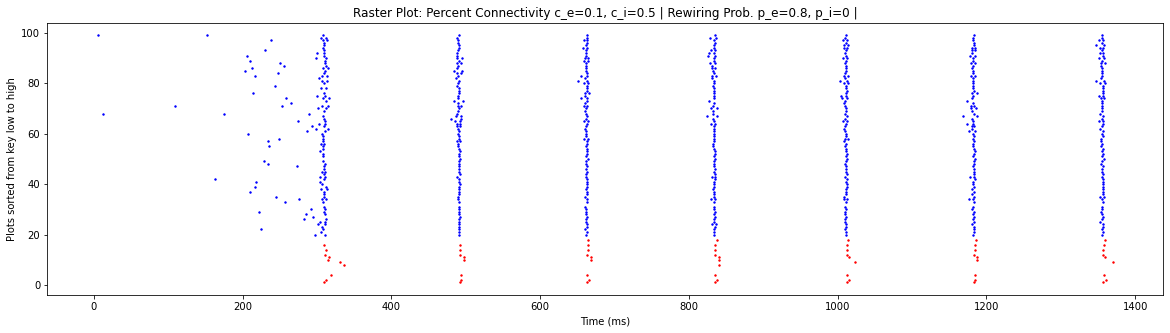

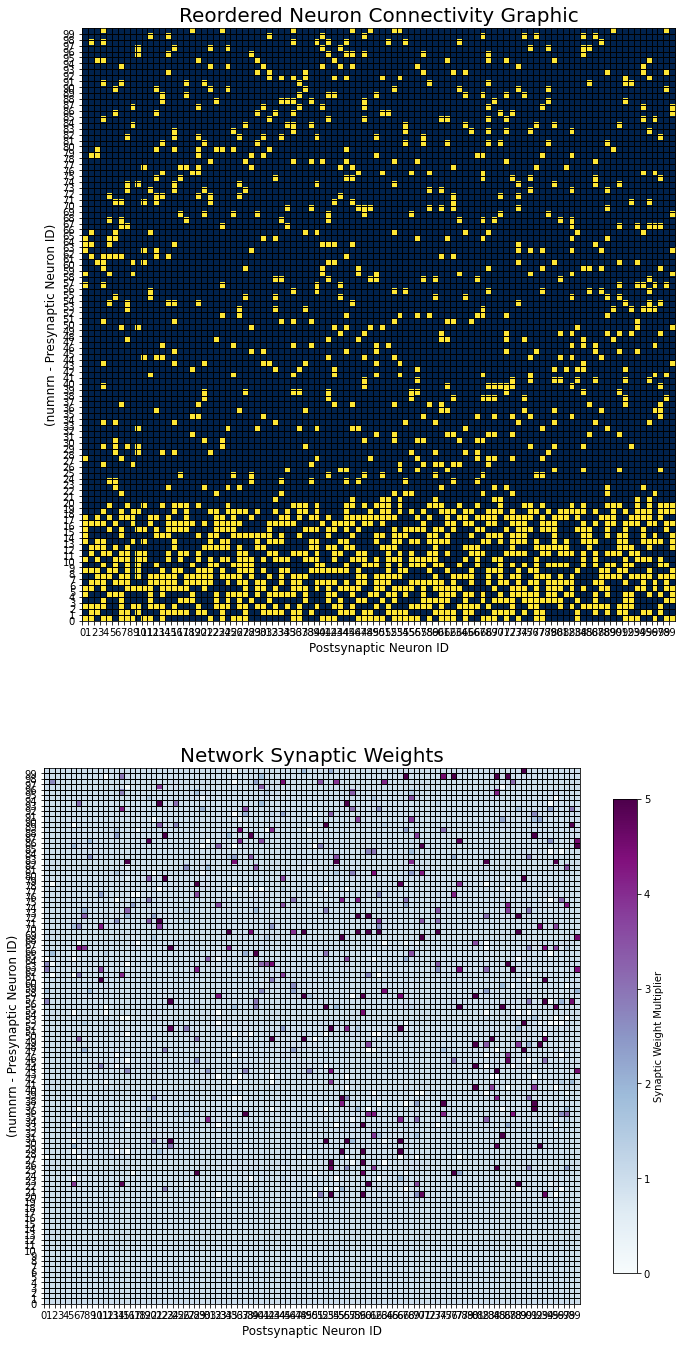

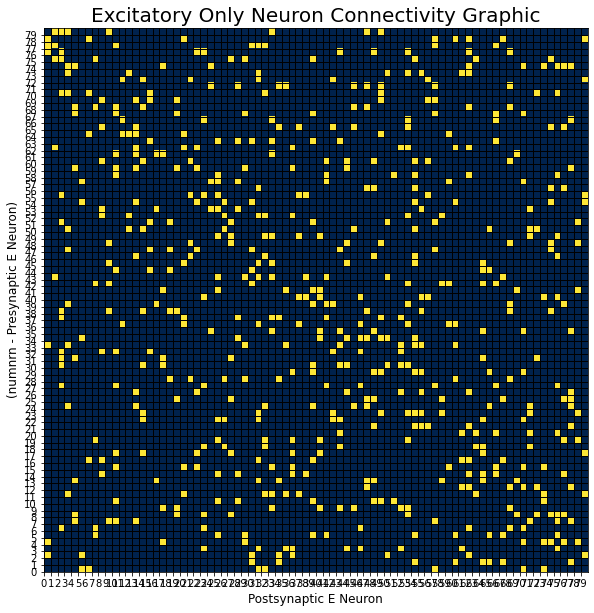

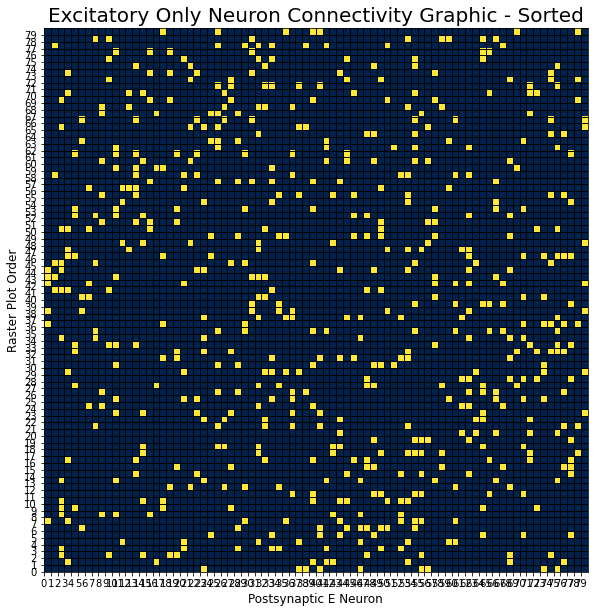

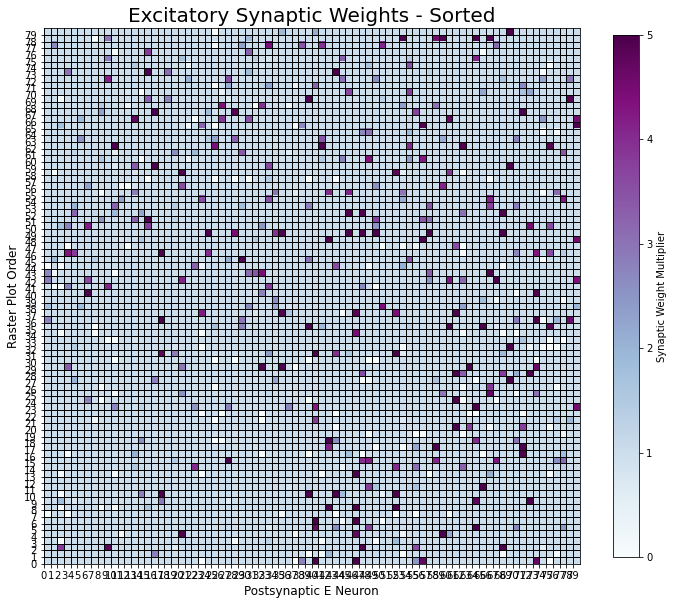

In [11]:
neurons,nc_Matrix = init_nrn(numnrn) #initializes neurons and creates universal list.

def mainProgramLoop():
    V_data = np.empty((len(neurons),Ntimes)) #Membrane potential of neurons
    w_data = np.empty((len(neurons),Ntimes,len(neurons))) #Synaptic weight for each connection of each neuron at each t_ind.
    
    for t_ind in range(Ntimes):
        
        #Records timing of spikes (in t/stepSize)
        updateSpikeTime(t_ind)
        #Updates the input synaptic current to be used in RK4
        updateSyn(t_ind)
        #A function to update the solutions for all neurons' D.E.s
        RK4(t_ind)

        zeroTempVars() #Resets temporary variables like Isyn
        
        for nrn in neurons:
            V_data[nrn.ID,t_ind] = nrn.solutions[3]
            w_data[nrn.ID,t_ind] = nrn.connectionWeights

    beep(makeSound) #Plays beeps as last line of code.
    plot_sorted(0,nc_Matrix)
    plot_mat_onlyE()
    return V_data,w_data

    
V_data,w_data = mainProgramLoop()
